In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
import glob
import math
from collections import Counter
import re

import openpyxl
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%config InlineBackend.figure_format = 'retina'
from pandas.plotting import table
import scipy.stats
from statannot import add_stat_annotation
from sklearn.neighbors import KernelDensity

import matplotlib.style
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib_venn import venn3, venn2

# Say, "the default sans-serif font is Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.loc'] = "upper left"
mpl.rcParams['figure.facecolor'] = "white"

from lib import parallel_run, geo, misc, seqs, count, gene_ids, align, homer_tools, bedtools, gprofiler, pathway_analysis, homer_logos_table

/tmp/ipykernel_44432/1581114592.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
genome_file = "reference/Homo_sapiens.GRCh38.dna.toplevel.fa"
transcriptome_file = "reference/Homo_sapiens.GRCh38.cdna.all.fa.gz"
gene_annotations = "reference/Homo_sapiens.GRCh38.99.gtf"
homer_genome = "hg38"

outs_folder = "data/ChIP-Seq/outs"
atac_folder = "data/ATAC-Seq/hiPSCCM-ERRagKO/tags/"
max_distance_to_tss = 5000
misc.make_sure_folder_exists("logs")

In [6]:
p300_folder = "data/ChIP-Seq/p300"
samples_info = pd.read_csv(os.path.join(p300_folder, "SraRunTable.txt"))
samples_info = samples_info.loc[(samples_info.Organism == "Homo sapiens") & (samples_info.chip_antibody == "anti-acetyl-CBP/p300 (rabbit polyclonal)"), :]
samples_info

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,catalog/batch_number,Center Name,chip_antibody,...,LibrarySource,Organism,Platform,ReleaseDate,Sample Name,source_name,SRA Study,tissue,gender,strain
0,SRR350618,ChIP-Seq,36,944864748,PRJNA147085,SAMN00736136,744320943,4771/lot 2,GEO,anti-acetyl-CBP/p300 (rabbit polyclonal),...,GENOMIC,Homo sapiens,ILLUMINA,2011-12-05T00:00:00Z,GSM807734,HumanAdultHeart_acCBP-p300,SRP008658,heart,male,NaN
1,SRR350619,ChIP-Seq,36,974646468,PRJNA147085,SAMN00736137,751126671,4771/lot 2,GEO,anti-acetyl-CBP/p300 (rabbit polyclonal),...,GENOMIC,Homo sapiens,ILLUMINA,2011-12-05T00:00:00Z,GSM807735,HumanFetaltHeart_acCBP-p300,SRP008658,heart,NaN,NaN


In [7]:
p300_raw = os.path.join(p300_folder, "raw")
for row in samples_info.itertuples():
    geo.dump_fastq(row.Run, p300_raw, parallel_run.SimpleRunner())

Dumping GEO run SRR350618 into data/ChIP-Seq/p300/raw
Dumping GEO run SRR350619 into data/ChIP-Seq/p300/raw


In [11]:
p300_aligned = os.path.join(p300_folder, "aligned")
misc.make_sure_folder_exists(p300_aligned)
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_align.log"), threads=10)
for row in samples_info.itertuples():
    fastq = os.path.join(p300_raw, f"{row.Run}_1.fastq.gz")
    align.align_chipseq(fastq, p300_aligned, genome_file, runner, max_mem_gb=45)           
    runner.run(dry=False)

No commands to run
Running the following command sequence:
{ bowtie2 -p 10 -N 1 -t -x reference/Homo_sapiens.GRCh38.dna.toplevel.fa.Bowtie_index/idx -U 'data/ChIP-Seq/p300/raw/SRR350619_1.fastq.gz' | samtools view -bSF4 - > 'data/ChIP-Seq/p300/aligned/SRR350619_1.bam' && samtools sort -@ 10 -o 'data/ChIP-Seq/p300/aligned/SRR350619_1.sorted.bam' -O bam -T 'data/ChIP-Seq/p300/aligned/SRR350619_1.sorted.bam' -m 4G 'data/ChIP-Seq/p300/aligned/SRR350619_1.bam' && samtools rmdup -s 'data/ChIP-Seq/p300/aligned/SRR350619_1.sorted.bam' 'data/ChIP-Seq/p300/aligned/SRR350619_1.unique.bam' && samtools view -bq 1 'data/ChIP-Seq/p300/aligned/SRR350619_1.unique.bam' > 'data/ChIP-Seq/p300/aligned/SRR350619_1.unique1.bam' && samtools index 'data/ChIP-Seq/p300/aligned/SRR350619_1.unique1.bam' && rm 'data/ChIP-Seq/p300/aligned/SRR350619_1.bam' 'data/ChIP-Seq/p300/aligned/SRR350619_1.sorted.bam' 'data/ChIP-Seq/p300/aligned/SRR350619_1.unique.bam' && echo Finished successfully ; } >> 'logs/chipseq_align.lo

In [12]:
# Homer directories
p300_tags = os.path.join(p300_folder, "tags")
misc.make_sure_folder_exists(p300_tags)
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_tag_dirs.log"), threads=10)            
for row in samples_info.itertuples():
    file = os.path.join(p300_aligned, f"{row.Run}_1.unique1.bam")
    dest_dir = os.path.join(p300_tags, f"{row.source_name}.tags")
    homer_tools.make_tag_directory(file, runner, tag_directory=dest_dir, single=True)
    runner.run(dry=False)

Running the following command sequence:
{ makeTagDirectory 'data/ChIP-Seq/p300/tags/HumanAdultHeart_acCBP-p300.tags'  -single 'data/ChIP-Seq/p300/aligned/SRR350618_1.unique1.bam' && echo Finished successfully ; } >> 'logs/chipseq_tag_dirs.log' 2>&1
Running the following command sequence:
{ makeTagDirectory 'data/ChIP-Seq/p300/tags/HumanFetaltHeart_acCBP-p300.tags'  -single 'data/ChIP-Seq/p300/aligned/SRR350619_1.unique1.bam' && echo Finished successfully ; } >> 'logs/chipseq_tag_dirs.log' 2>&1


In [16]:
# Peaks
p300_peaks = os.path.join(p300_folder, "peaks")
misc.make_sure_folder_exists(p300_peaks)
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_peaks.log"), threads=10)            
for row in samples_info.itertuples():
    tags_dir = os.path.join(p300_tags, f"{row.source_name}.tags")
    peak_file = os.path.join(p300_peaks, f"{row.source_name}.peaks")
    homer_tools.find_peaks(tags_dir, peak_file, runner, peak_size=1000, min_tags_per_peak=19)
    runner.run(dry=False)

Running the following command sequence:
{ findPeaks 'data/ChIP-Seq/p300/tags/HumanAdultHeart_acCBP-p300.tags' -size 1000     -o 'data/ChIP-Seq/p300/peaks/HumanAdultHeart_acCBP-p300.peaks' -minTagThreshold 19   && echo Finished successfully ; } >> 'logs/chipseq_peaks.log' 2>&1
Running the following command sequence:
{ findPeaks 'data/ChIP-Seq/p300/tags/HumanFetaltHeart_acCBP-p300.tags' -size 1000     -o 'data/ChIP-Seq/p300/peaks/HumanFetaltHeart_acCBP-p300.peaks' -minTagThreshold 19   && echo Finished successfully ; } >> 'logs/chipseq_peaks.log' 2>&1


# MED1

In [8]:
med1_folder = "data/ChIP-Seq/med1"
samples_info = pd.read_csv(os.path.join(med1_folder, "SraRunTable.txt"))
samples_info = samples_info.loc[(samples_info.source_name == "purified cardiomyocyte WT") & 
                                ((samples_info.chip_antibody == "MED1 (A300-793A\, lot:A300-793A)") |
                                 (samples_info.chip_antibody == "Input")), :]

samples_info

,Run,Assay Type,AssemblyName,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Cell_type,Center Name,...,LibraryLayout,LibrarySelection,LibrarySource,Organism,Passages,Platform,ReleaseDate,Sample Name,source_name,SRA Study
5,SRR4032195,ChIP-Seq,GCA_000001405.13,50,601522472,PRJNA339028,SAMN05578155,235075011,iPS-derived cardiomyocytes,GEO,...,SINGLE,ChIP,GENOMIC,Homo sapiens,20-30,ILLUMINA,2016-12-15T00:00:00Z,GSM2279961,purified cardiomyocyte WT,SRP082271
6,SRR4032196,ChIP-Seq,GCA_000001405.13,50,648051482,PRJNA339028,SAMN05578154,246750933,iPS-derived cardiomyocytes,GEO,...,SINGLE,ChIP,GENOMIC,Homo sapiens,20-30,ILLUMINA,2016-12-15T00:00:00Z,GSM2279962,purified cardiomyocyte WT,SRP082271
12,SRR4032203,ChIP-Seq,GCA_000001405.13,49,1912646510,PRJNA339028,SAMN05578147,677838472,iPS-derived cardiomyocytes,GEO,...,SINGLE,ChIP,GENOMIC,Homo sapiens,20-30,ILLUMINA,2016-12-15T00:00:00Z,GSM2279969,purified cardiomyocyte WT,SRP082271
13,SRR4032204,ChIP-Seq,GCA_000001405.13,49,1504353755,PRJNA339028,SAMN05578146,519090128,iPS-derived cardiomyocytes,GEO,...,SINGLE,ChIP,GENOMIC,Homo sapiens,20-30,ILLUMINA,2016-12-15T00:00:00Z,GSM2279970,purified cardiomyocyte WT,SRP082271
20,SRR4032211,ChIP-Seq,GCA_000001405.13,50,1257705701,PRJNA339028,SAMN05578139,332916777,iPS-derived cardiomyocytes,GEO,...,SINGLE,ChIP,GENOMIC,Homo sapiens,20-30,ILLUMINA,2016-12-15T00:00:00Z,GSM2279980,purified cardiomyocyte WT,SRP082271
21,SRR4032212,ChIP-Seq,GCA_000001405.13,50,1388948420,PRJNA339028,SAMN05578138,363922963,iPS-derived cardiomyocytes,GEO,...,SINGLE,ChIP,GENOMIC,Homo sapiens,20-30,ILLUMINA,2016-12-15T00:00:00Z,GSM2279982,purified cardiomyocyte WT,SRP082271
27,SRR4032218,ChIP-Seq,GCA_000001405.13,50,1444504892,PRJNA339028,SAMN05578132,444770553,iPS-derived cardiomyocytes,GEO,...,SINGLE,ChIP,GENOMIC,Homo sapiens,20-30,ILLUMINA,2016-12-15T00:00:00Z,GSM2279995,purified cardiomyocyte WT,SRP082271
32,SRR4032223,ChIP-Seq,GCA_000001405.13,50,901005942,PRJNA339028,SAMN05578127,241903382,iPS-derived cardiomyocytes,GEO,...,SINGLE,ChIP,GENOMIC,Homo sapiens,20-30,ILLUMINA,2016-12-15T00:00:00Z,GSM2280001,purified cardiomyocyte WT,SRP082271
34,SRR4032225,ChIP-Seq,GCA_000001405.13,49,116390742,PRJNA339028,SAMN05578125,28198013,iPS-derived cardiomyocytes,GEO,...,SINGLE,ChIP,GENOMIC,Homo sapiens,20-30,ILLUMINA,2016-12-15T00:00:00Z,GSM2280003,purified cardiomyocyte WT,SRP082271
40,SRR4032231,ChIP-Seq,GCA_000001405.13,50,601522472,PRJNA339028,SAMN05578119,235072203,iPS-derived cardiomyocytes,GEO,...,SINGLE,ChIP,GENOMIC,Homo sapiens,20-30,ILLUMINA,2016-12-15T00:00:00Z,GSM2280009,purified cardiomyocyte WT,SRP082271


In [11]:
med1_raw = os.path.join(med1_folder, "raw")
for row in tqdm(samples_info.itertuples(), total=len(samples_info)):
    geo.dump_fastq(row.Run, med1_raw, parallel_run.SimpleRunner())

data/ChIP-Seq/med1/raw/SRR4032195_1.fastq.gz exists, skipping
data/ChIP-Seq/med1/raw/SRR4032196_1.fastq.gz exists, skipping
data/ChIP-Seq/med1/raw/SRR4032203_1.fastq.gz exists, skipping
data/ChIP-Seq/med1/raw/SRR4032204_1.fastq.gz exists, skipping
data/ChIP-Seq/med1/raw/SRR4032211_1.fastq.gz exists, skipping
data/ChIP-Seq/med1/raw/SRR4032212_1.fastq.gz exists, skipping
Dumping GEO run SRR4032218 into data/ChIP-Seq/med1/raw
Dumping GEO run SRR4032223 into data/ChIP-Seq/med1/raw
Dumping GEO run SRR4032225 into data/ChIP-Seq/med1/raw
Dumping GEO run SRR4032231 into data/ChIP-Seq/med1/raw
Dumping GEO run SRR4032232 into data/ChIP-Seq/med1/raw



In [12]:
med1_aligned = os.path.join(med1_folder, "aligned")
misc.make_sure_folder_exists(med1_aligned)
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_align.log"), threads=10)
for row in samples_info.itertuples():
    fastq = os.path.join(med1_raw, f"{row.Run}_1.fastq.gz")
    align.align_chipseq(fastq, med1_aligned, genome_file, runner, max_mem_gb=45)           
    runner.run(dry=False)

Running the following command sequence:
{ bowtie2 -p 10 -N 1 -t -x reference/Homo_sapiens.GRCh38.dna.toplevel.fa.Bowtie_index/idx -U 'data/ChIP-Seq/med1/raw/SRR4032195_1.fastq.gz' | samtools view -bSF4 - > 'data/ChIP-Seq/med1/aligned/SRR4032195_1.bam' && samtools sort -@ 10 -o 'data/ChIP-Seq/med1/aligned/SRR4032195_1.sorted.bam' -O bam -T 'data/ChIP-Seq/med1/aligned/SRR4032195_1.sorted.bam' -m 4G 'data/ChIP-Seq/med1/aligned/SRR4032195_1.bam' && samtools rmdup -s 'data/ChIP-Seq/med1/aligned/SRR4032195_1.sorted.bam' 'data/ChIP-Seq/med1/aligned/SRR4032195_1.unique.bam' && samtools view -bq 1 'data/ChIP-Seq/med1/aligned/SRR4032195_1.unique.bam' > 'data/ChIP-Seq/med1/aligned/SRR4032195_1.unique1.bam' && samtools index 'data/ChIP-Seq/med1/aligned/SRR4032195_1.unique1.bam' && rm 'data/ChIP-Seq/med1/aligned/SRR4032195_1.bam' 'data/ChIP-Seq/med1/aligned/SRR4032195_1.sorted.bam' 'data/ChIP-Seq/med1/aligned/SRR4032195_1.unique.bam' && echo Finished successfully ; } >> 'logs/chipseq_align.log' 2>&

In [13]:
# Homer directories
med1_tags = os.path.join(med1_folder, "tags")
misc.make_sure_folder_exists(med1_tags)
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_tag_dirs.log"), threads=10)            
for row in samples_info.itertuples():
    file = os.path.join(med1_aligned, f"{row.Run}_1.unique1.bam")
    name = ("MED1" if "MED1" in row.chip_antibody else "Input") + "_" + row.Run
    dest_dir = os.path.join(med1_tags, f"{name}.tags")
    homer_tools.make_tag_directory(file, runner, tag_directory=dest_dir, single=True)
    runner.run(dry=False)

Running the following command sequence:
{ makeTagDirectory 'data/ChIP-Seq/med1/tags/Input_SRR4032195.tags'  -single 'data/ChIP-Seq/med1/aligned/SRR4032195_1.unique1.bam' && echo Finished successfully ; } >> 'logs/chipseq_tag_dirs.log' 2>&1
Running the following command sequence:
{ makeTagDirectory 'data/ChIP-Seq/med1/tags/MED1_SRR4032196.tags'  -single 'data/ChIP-Seq/med1/aligned/SRR4032196_1.unique1.bam' && echo Finished successfully ; } >> 'logs/chipseq_tag_dirs.log' 2>&1
Running the following command sequence:
{ makeTagDirectory 'data/ChIP-Seq/med1/tags/Input_SRR4032203.tags'  -single 'data/ChIP-Seq/med1/aligned/SRR4032203_1.unique1.bam' && echo Finished successfully ; } >> 'logs/chipseq_tag_dirs.log' 2>&1
Running the following command sequence:
{ makeTagDirectory 'data/ChIP-Seq/med1/tags/MED1_SRR4032204.tags'  -single 'data/ChIP-Seq/med1/aligned/SRR4032204_1.unique1.bam' && echo Finished successfully ; } >> 'logs/chipseq_tag_dirs.log' 2>&1
Running the following command sequence:
{ 

In [7]:
med1_tags = os.path.join(med1_folder, "tags")

for ab in ["MED1", "Input"]:
    dest_dir = os.path.join(med1_tags, f"{ab}_pooled.tags")
    if os.path.exists(dest_dir):
        continue
    
    tag_dirs = []
    for row in samples_info.itertuples():
        if ab in row.chip_antibody and row.differentiation_stage == "Differentiation D32":
            name = ab + "_" + row.Run
            tag_dirs.append(os.path.join(med1_tags, f"{name}.tags"))

    homer_tools.pool_tag_directories(tag_dirs, dest_dir, parallel_run.SimpleRunner())

In [9]:
med1_tags = os.path.join(med1_folder, "tags")
bigwigs_folder = os.path.join(med1_folder, "bigwigs")
misc.make_sure_folder_exists(bigwigs_folder)

for ab in ["MED1", "Input"]:
    pooled_dir = os.path.join(med1_tags, f"{ab}_pooled.tags")
    bigwig = homer_tools.make_bigwig(pooled_dir, bedtools.chromosome_sizes(genome_file))
    os.rename(bigwig, os.path.join(bigwigs_folder, os.path.basename(bigwig)))

Running command w/120 threads: makeUCSCfile 'data/ChIP-Seq/med1/tags/MED1_pooled.tags' -o auto -bigWig 'reference/Homo_sapiens.GRCh38.dna.toplevel.fa.chrom_sizes' 
Running command w/120 threads: makeUCSCfile 'data/ChIP-Seq/med1/tags/Input_pooled.tags' -o auto -bigWig 'reference/Homo_sapiens.GRCh38.dna.toplevel.fa.chrom_sizes' 


In [9]:
peaks_folder = os.path.join(med1_folder, "peaks")
misc.make_sure_folder_exists(peaks_folder)

peaks_file = os.path.join(peaks_folder, "med1_pooled.peaks")
homer_tools.find_peaks(os.path.join(med1_tags, "MED1_pooled.tags"), peaks_file, parallel_run.SimpleRunner(), input_tags_dir=os.path.join(med1_tags, "Input_pooled.tags"))

# GATA4

In [15]:
gata4_folder = "data/ChIP-Seq/gata4/"
gata4_raw = os.path.join(gata4_folder, "raw")

samples_info = pd.read_csv(os.path.join(gata4_folder, "SraRunTable.txt"))
samples_info = samples_info.loc[(samples_info.source_name == "purified cardiomyocyte WT") & (samples_info.differentiation_stage == "Differentiation D32") &
                                ((samples_info.chip_antibody == "GATA4 (sc1237\, lot:E0912)") |
                                 (samples_info.chip_antibody == "Input")), :]

samples_info.iloc[:, :15]

,Run,Assay Type,AssemblyName,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Cell_type,Center Name,chip_antibody,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region
0,SRR4032190,ChIP-Seq,GCA_000001405.13,50,1465797961,PRJNA339028,SAMN05578160,471689997,iPS-derived cardiomyocytes,GEO,"GATA4 (sc1237\, lot:E0912)",public,"bam,sra","s3,ncbi,gs","gs.US,s3.us-east-1,ncbi.public"
5,SRR4032195,ChIP-Seq,GCA_000001405.13,50,601522472,PRJNA339028,SAMN05578155,235075011,iPS-derived cardiomyocytes,GEO,Input,public,"sra,bam","gs,ncbi,s3","s3.us-east-1,gs.US,ncbi.public"
8,SRR4032198,ChIP-Seq,GCA_000001405.13,49,1542744030,PRJNA339028,SAMN05578152,532463903,iPS-derived cardiomyocytes,GEO,"GATA4 (sc1237\, lot:E0912)",public,"bam,sra","gs,ncbi,s3","ncbi.public,s3.us-east-1,gs.US"
13,SRR4032203,ChIP-Seq,GCA_000001405.13,49,1912646510,PRJNA339028,SAMN05578147,677838472,iPS-derived cardiomyocytes,GEO,Input,public,"sra,bam","ncbi,s3,gs","gs.US,ncbi.public,s3.us-east-1"
16,SRR4032206,ChIP-Seq,GCA_000001405.13,50,1461605711,PRJNA339028,SAMN05578144,380312598,iPS-derived cardiomyocytes,GEO,"GATA4 (sc1237\, lot:E0912)",public,"bam,sra","ncbi,s3,gs","ncbi.public,gs.US,s3.us-east-1"
21,SRR4032211,ChIP-Seq,GCA_000001405.13,50,1257705701,PRJNA339028,SAMN05578139,332916777,iPS-derived cardiomyocytes,GEO,Input,public,"sra,bam","ncbi,gs,s3","gs.US,s3.us-east-1,ncbi.public"
28,SRR4032218,ChIP-Seq,GCA_000001405.13,50,1444504892,PRJNA339028,SAMN05578132,444770553,iPS-derived cardiomyocytes,GEO,Input,public,"sra,bam","s3,ncbi,gs","gs.US,ncbi.public,s3.us-east-1"
33,SRR4032223,ChIP-Seq,GCA_000001405.13,50,901005942,PRJNA339028,SAMN05578127,241903382,iPS-derived cardiomyocytes,GEO,Input,public,"sra,bam","ncbi,gs,s3","gs.US,ncbi.public,s3.us-east-1"
36,SRR4032226,ChIP-Seq,GCA_000001405.13,50,2029732388,PRJNA339028,SAMN05578124,698265252,iPS-derived cardiomyocytes,GEO,"GATA4 (sc1237\, lot:E0912)",public,"bam,sra","ncbi,s3,gs","gs.US,ncbi.public,s3.us-east-1"
41,SRR4032231,ChIP-Seq,GCA_000001405.13,50,601522472,PRJNA339028,SAMN05578119,235072203,iPS-derived cardiomyocytes,GEO,Input,public,"sra,bam","gs,ncbi,s3","s3.us-east-1,gs.US,ncbi.public"


In [10]:
for row in tqdm(samples_info.itertuples(), total=len(samples_info)):
    geo.dump_fastq(row.Run, gata4_raw, parallel_run.SimpleRunner(), gzip=False)

Dumping GEO run SRR4032190 into data/ChIP-Seq/gata4/raw
Dumping GEO run SRR4032195 into data/ChIP-Seq/gata4/raw
Dumping GEO run SRR4032198 into data/ChIP-Seq/gata4/raw
Dumping GEO run SRR4032203 into data/ChIP-Seq/gata4/raw
Dumping GEO run SRR4032206 into data/ChIP-Seq/gata4/raw
Dumping GEO run SRR4032211 into data/ChIP-Seq/gata4/raw
Dumping GEO run SRR4032218 into data/ChIP-Seq/gata4/raw
Dumping GEO run SRR4032223 into data/ChIP-Seq/gata4/raw
Dumping GEO run SRR4032226 into data/ChIP-Seq/gata4/raw
Dumping GEO run SRR4032231 into data/ChIP-Seq/gata4/raw



In [8]:
gata4_aligned = os.path.join(gata4_folder, "aligned")
misc.make_sure_folder_exists(gata4_aligned)
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_align.log"), threads=10)
for row in samples_info.itertuples():
    fastq = os.path.join(gata4_raw, f"{row.Run}_1.fastq.gz")
    align.align_chipseq(fastq, gata4_aligned, genome_file, runner, max_mem_gb=45)           
    runner.run(dry=False)

Running the following command sequence:
{ bowtie2 -p 10 -N 1 -t -x reference/Homo_sapiens.GRCh38.dna.toplevel.fa.Bowtie_index/idx -U 'data/ChIP-Seq/gata4/raw/SRR4032190_1.fastq.gz' | samtools view -bSF4 - > 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.bam' && samtools sort -@ 11 -o 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.sorted.bam' -O bam -T 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.sorted.bam' -m 4G 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.bam' && samtools rmdup -s 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.sorted.bam' 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.unique.bam' && samtools view -bq 1 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.unique.bam' > 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.unique1.bam' && samtools index 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.unique1.bam' && rm 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.bam' 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.sorted.bam' 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.unique.bam' && echo Finished successfully ; } >> 'logs/chipseq_a

In [10]:
# Homer directories
gata4_tags = os.path.join(gata4_folder, "tags")
misc.make_sure_folder_exists(gata4_tags)
runner = parallel_run.LocalRunner(os.path.join("logs", f"chipseq_tag_dirs.log"), threads=10)            
for row in samples_info.itertuples():
    file = os.path.join(gata4_aligned, f"{row.Run}_1.unique1.bam")
    name = ("GATA4" if "GATA4" in row.chip_antibody else "Input") + "_" + row.Run
    dest_dir = os.path.join(gata4_tags, f"{name}.tags")
    homer_tools.make_tag_directory(file, runner, tag_directory=dest_dir, single=True)
    runner.run(dry=False)

Running the following command sequence:
{ makeTagDirectory 'data/ChIP-Seq/gata4/tags/GATA4_SRR4032190.tags'  -single 'data/ChIP-Seq/gata4/aligned/SRR4032190_1.unique1.bam' && echo Finished successfully ; } >> 'logs/chipseq_tag_dirs.log' 2>&1
Running the following command sequence:
{ makeTagDirectory 'data/ChIP-Seq/gata4/tags/Input_SRR4032195.tags'  -single 'data/ChIP-Seq/gata4/aligned/SRR4032195_1.unique1.bam' && echo Finished successfully ; } >> 'logs/chipseq_tag_dirs.log' 2>&1
Running the following command sequence:
{ makeTagDirectory 'data/ChIP-Seq/gata4/tags/GATA4_SRR4032198.tags'  -single 'data/ChIP-Seq/gata4/aligned/SRR4032198_1.unique1.bam' && echo Finished successfully ; } >> 'logs/chipseq_tag_dirs.log' 2>&1
Running the following command sequence:
{ makeTagDirectory 'data/ChIP-Seq/gata4/tags/Input_SRR4032203.tags'  -single 'data/ChIP-Seq/gata4/aligned/SRR4032203_1.unique1.bam' && echo Finished successfully ; } >> 'logs/chipseq_tag_dirs.log' 2>&1
Running the following command se

In [11]:
gata4_tags = os.path.join(gata4_folder, "tags")

for ab in ["GATA4", "Input"]:
    dest_dir = os.path.join(gata4_tags, f"{ab}_pooled.tags")
    if os.path.exists(dest_dir):
        continue
    
    tag_dirs = []
    for row in samples_info.itertuples():
        if ab in row.chip_antibody:
            name = ab + "_" + row.Run
            tag_dirs.append(os.path.join(gata4_tags, f"{name}.tags"))

    homer_tools.pool_tag_directories(tag_dirs, dest_dir, parallel_run.SimpleRunner())

In [6]:
gata4_tags = os.path.join(gata4_folder, "tags")
bigwigs_folder = os.path.join(gata4_folder, "bigwigs")
misc.make_sure_folder_exists(bigwigs_folder)

for ab in ["GATA4", "Input"]:
    pooled_dir = os.path.join(gata4_tags, f"{ab}_pooled.tags")
    bigwig = homer_tools.make_bigwig(pooled_dir, bedtools.chromosome_sizes(genome_file))
    os.rename(bigwig, os.path.join(bigwigs_folder, os.path.basename(bigwig)))

Running command w/120 threads: makeUCSCfile 'data/ChIP-Seq/gata4/tags/GATA4_pooled.tags' -o auto -bigWig 'reference/Homo_sapiens.GRCh38.dna.toplevel.fa.chrom_sizes' 
Running command w/120 threads: makeUCSCfile 'data/ChIP-Seq/gata4/tags/Input_pooled.tags' -o auto -bigWig 'reference/Homo_sapiens.GRCh38.dna.toplevel.fa.chrom_sizes' 


In [42]:
gata4_tags = os.path.join(gata4_folder, "tags")
peaks_folder = os.path.join(gata4_folder, "peaks")
misc.make_sure_folder_exists(peaks_folder)

peaks_file = os.path.join(peaks_folder, "gata4_pooled.peaks")
runner = parallel_run.LocalRunner("logs/gata4_peaks.log")
homer_tools.find_peaks(os.path.join(gata4_tags, "GATA4_pooled.tags"), peaks_file, runner=runner, 
                       input_tags_dir=os.path.join(gata4_tags, "Input_pooled.tags"),
                       fold_over_input=3)

runner.run()

Running the following command sequence:
{ findPeaks 'data/ChIP-Seq/gata4/tags/GATA4_pooled.tags'  -i 'data/ChIP-Seq/gata4/tags/Input_pooled.tags'    -o 'data/ChIP-Seq/gata4/peaks/gata4_pooled.peaks'  -F 3     && echo Finished successfully ; } >> 'logs/gata4_peaks.log' 2>&1


In [48]:
peaks_data = pd.read_csv(peaks_file, sep="\t", skiprows=38)
print(len(peaks_data))
peaks_data = peaks_data[peaks_data.chr == "19"]
peaks_data = peaks_data[(peaks_data.start > 55157000) & (peaks_data.start < 55160000)]
peaks_data

23598


,#PeakID,chr,start,end,strand,Normalized Tag Count,Not used,findPeaks Score,Total Tags,Control Tags (normalized to IP Experiment),Fold Change vs Control,p-value vs Control,Fold Change vs Local,p-value vs Local,Clonal Fold Change
3033,19-41,19,55158912,55159096,+,9.39,0.0,107.0,107.0,16.1,6.65,1.230000e-50,8.91,1.890000e-62,0.93
9188,19-142,19,55157659,55157843,+,5.44,0.0,63.0,62.0,19.7,3.15,2.140000e-14,4.49,2.050000e-21,0.95


In [5]:
gene_ids_map = pd.read_csv("data/gene_id_map_human.tsv", sep="\t")
gene_ids_map = dict(zip(gene_ids_map["id"], gene_ids_map.name))

Running command w/120 threads: mergePeaks -d 400 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks' 'data/ChIP-Seq/gata4/peaks/gata4_pooled.peaks' -matrix 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks.merged.matrix' -gsize 900000000.0 -venn 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks.merged.venn' > 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks.merged.peaks'
Exporting ERRg_only
Create data/ChIP-Seq/gata4/peaks/ERRg_only.annotated.peaks
Running command w/120 threads: annotatePeaks.pl 'data/ChIP-Seq/gata4/peaks/ERRg_only.lchrom.peaks' hg38     > 'data/ChIP-Seq/gata4/peaks/ERRg_only.annotated.peaks'
Save data/ChIP-Seq/gata4/peaks/ERRg_only.bed
Running command w/120 threads: pos2bed.pl 'data/ChIP-Seq/gata4/peaks/ERRg_only.annotated.peaks' -o 'data/ChIP-Seq/gata4/peaks/ERRg_only.bed'
Add [ERRg_only peaks] to tables/ERRg+GATA4_peaks.xlsx

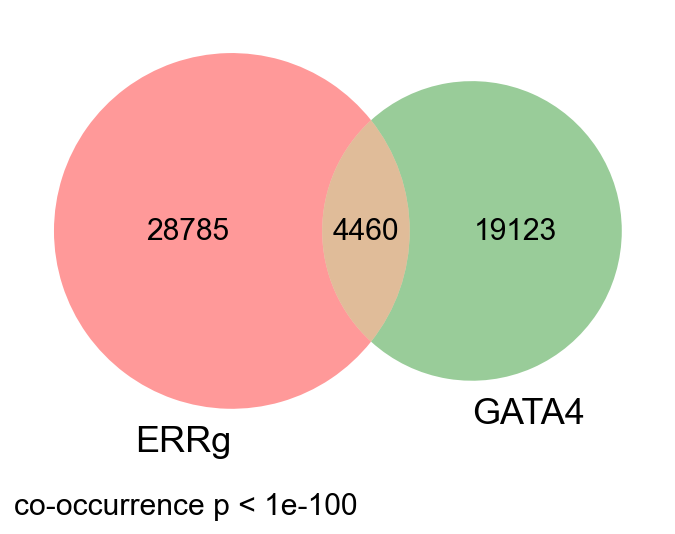

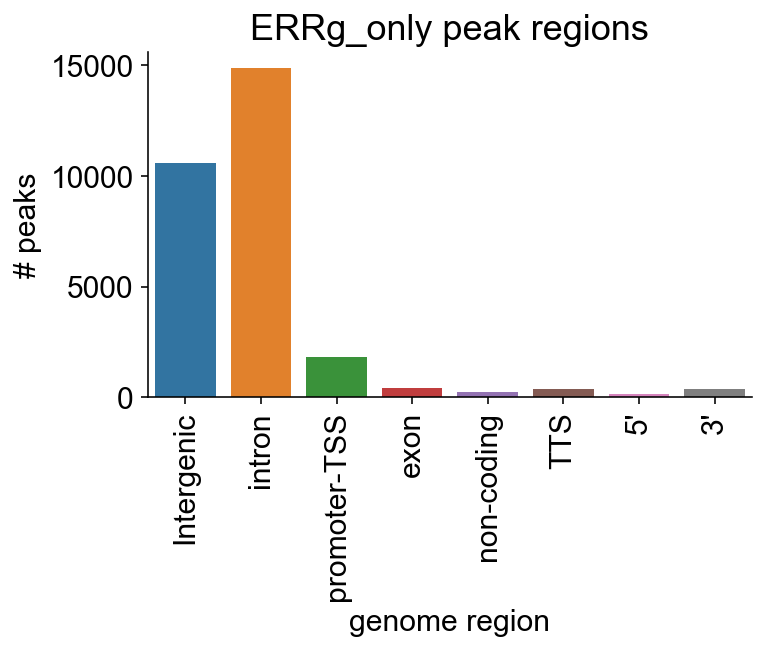

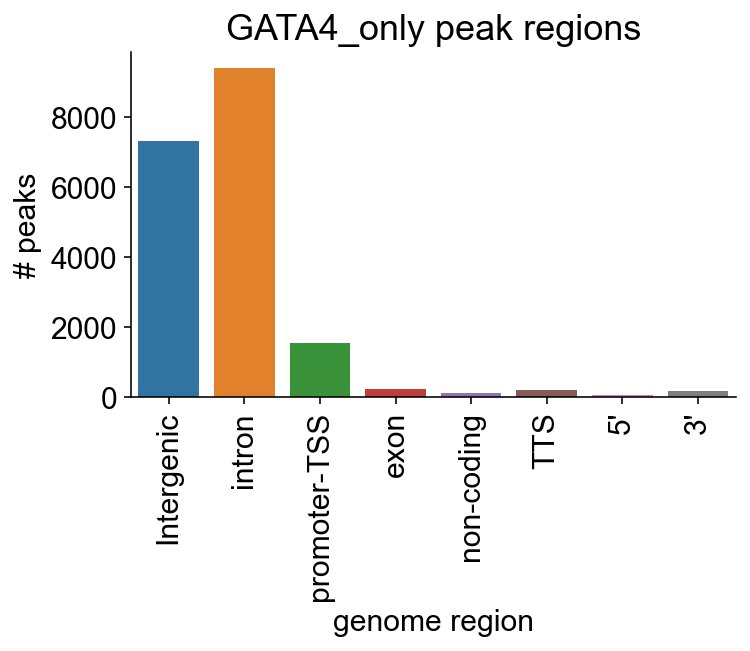

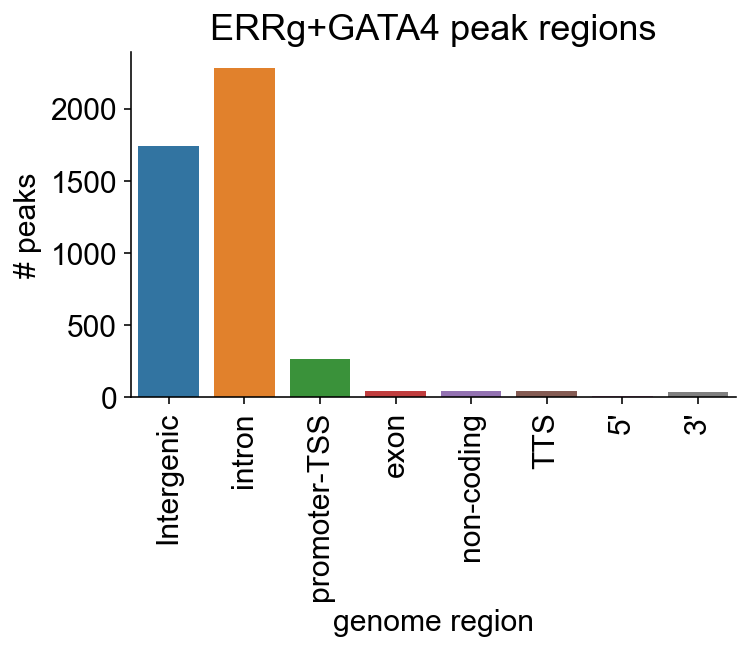

In [21]:
pics_folder = "pics/gata4"
misc.make_sure_folder_exists(pics_folder)
homer_tools.compare_and_export_peaks("data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled.peaks", "data/ChIP-Seq/gata4/peaks/gata4_pooled.peaks",
                                     homer_genome, "human", gene_ids_map, 
                                     "ERRg", "GATA4", "ERRg+GATA4",
                                     "data/ChIP-Seq/gata4/peaks/", pics_folder, "tables", max_distance=400, genome_size=9e8)

# GATA6

In [5]:
gata6_peaks_data = pd.read_excel("data/ChIP-Seq/gata6/elife-53278-supp4-v2.xlsx", sheet_name="D. GATA6_WT_ChIP_D8", skiprows=2)

In [7]:
peaks_folder = "data/ChIP-Seq/gata6/peaks"
misc.make_sure_folder_exists(peaks_folder)
gata6_peaks_file_hg19 = os.path.join(peaks_folder, "gata6_hg19.peaks")
gata6_peaks_data.to_csv(gata6_peaks_file_hg19, sep="\t", index=False)
gata6_bed_file_hg19 = misc.replace_extension(gata6_peaks_file_hg19, "bed")
homer_tools.peak_file_to_bed(gata6_peaks_file_hg19, output_bed=gata6_bed_file_hg19)
gata6_bed_file_hg38 = os.path.join(peaks_folder, "gata6_hg38.bed")
bedtools.liftover(gata6_bed_file_hg19, "hg19ToHg38", gata6_bed_file_hg38)
gata6_peaks_file_hg38 = misc.replace_extension(gata6_bed_file_hg38, "peaks")
homer_tools.bed_file_to_peak(gata6_bed_file_hg38, output_peaks=gata6_peaks_file_hg38)

Running command w/120 threads: pos2bed.pl 'data/ChIP-Seq/gata6/peaks/gata6_hg19.peaks' -o 'data/ChIP-Seq/gata6/peaks/gata6_hg19.bed'
Running command w/120 threads: liftOver -bedPlus=5 'data/ChIP-Seq/gata6/peaks/gata6_hg19.bed' reference/liftOver/hg19ToHg38.over.chain.gz 'data/ChIP-Seq/gata6/peaks/gata6_hg38.bed' /dev/null
Running command w/120 threads: bed2pos.pl 'data/ChIP-Seq/gata6/peaks/gata6_hg38.bed' -o 'data/ChIP-Seq/gata6/peaks/gata6_hg38.peaks'


'data/ChIP-Seq/gata6/peaks/gata6_hg38.peaks'

In [18]:
gene_ids_map = pd.read_csv("data/gene_id_map_human.tsv", sep="\t")
gene_ids_map = dict(zip(gene_ids_map["id"], gene_ids_map.name))

Running command w/120 threads: mergePeaks -d given 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks' 'data/ChIP-Seq/gata6/peaks/gata6_hg38.peaks' -matrix 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.matrix' -gsize 900000000.0 -venn 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.venn' > 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.peaks'


('data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.venn',
 (31987, 55311, 1261),
 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.peaks',
 85365.47294856429)

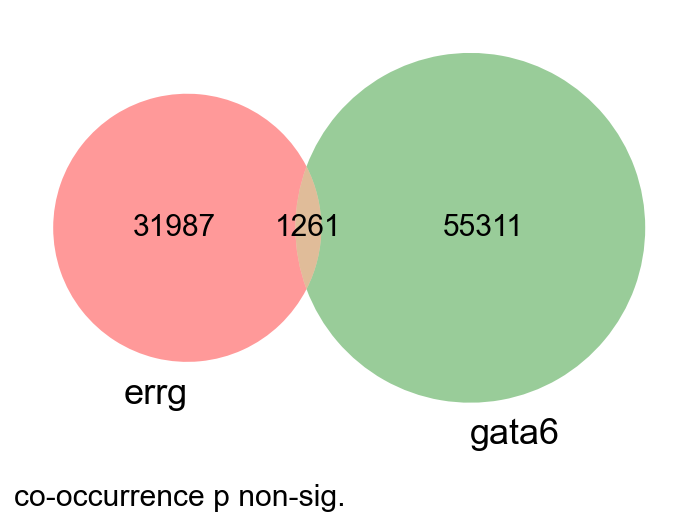

In [20]:
homer_tools.compare_peaks("data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks", "data/ChIP-Seq/gata6/peaks/gata6_hg38.peaks",
                         "errg", "gata6", genome_size=9e8)

Running command w/120 threads: mergePeaks -d 400 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks' 'data/ChIP-Seq/gata6/peaks/gata6_hg38.peaks' -matrix 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.matrix' -gsize 900000000.0 -venn 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.venn' > 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.peaks'
Exporting ERRg_only
Create data/ChIP-Seq/gata6/peaks/ERRg_only.annotated.peaks
Running command w/120 threads: annotatePeaks.pl 'data/ChIP-Seq/gata6/peaks/ERRg_only.peaks' hg38     > 'data/ChIP-Seq/gata6/peaks/ERRg_only.annotated.peaks'
Save data/ChIP-Seq/gata6/peaks/ERRg_only.bed
Running command w/120 threads: pos2bed.pl 'data/ChIP-Seq/gata6/peaks/ERRg_only.annotated.peaks' -o 'data/ChIP-Seq/gata6/peaks/ERRg_only.bed'
Add [ERRg_only peaks] to tables/ER

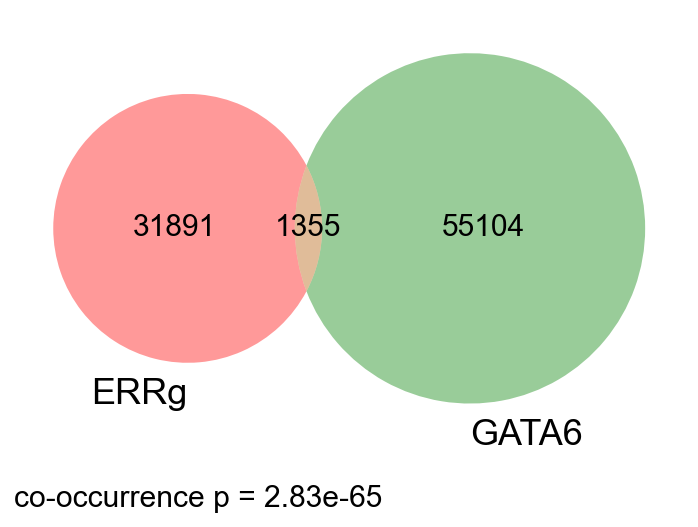

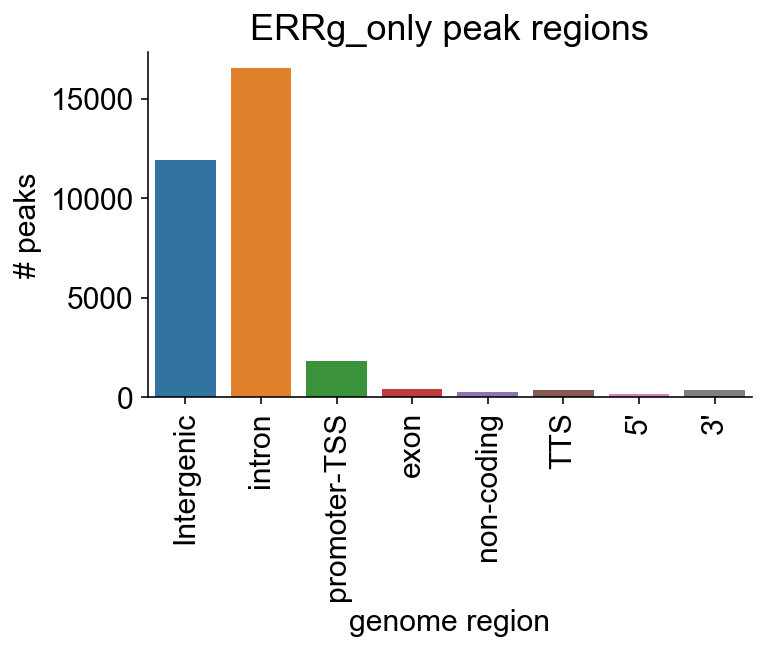

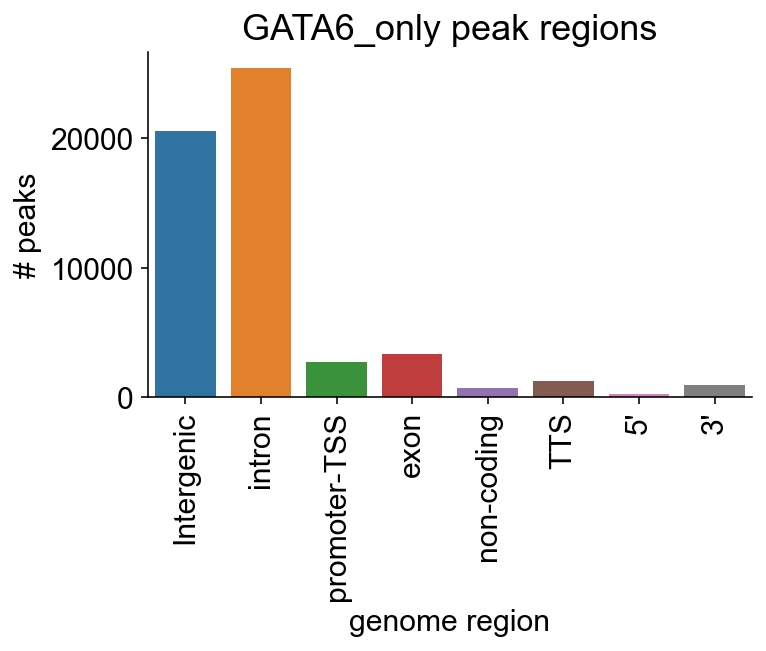

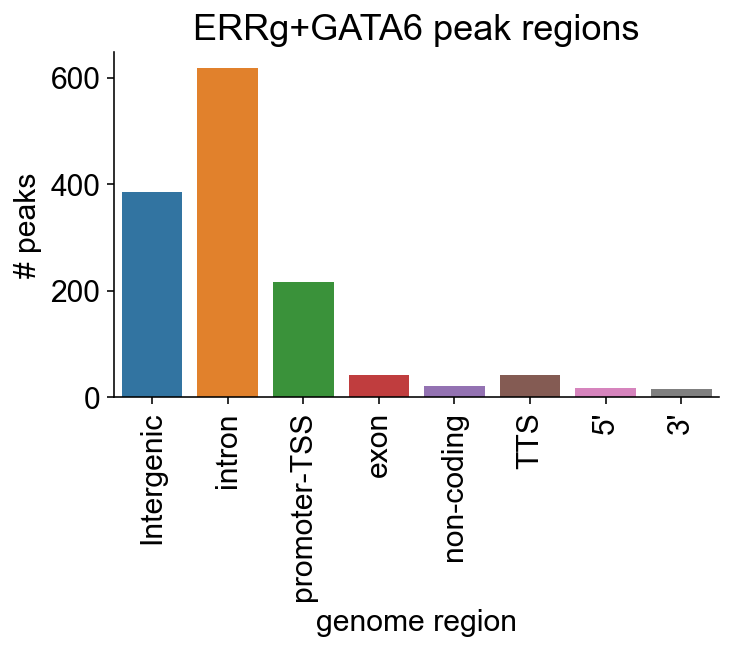

In [19]:
pics_folder = "pics/gata6"
misc.make_sure_folder_exists(pics_folder)
gata6_peaks_file_hg38 = "data/ChIP-Seq/gata6/peaks/gata6_hg38.peaks"
peaks_folder = "data/ChIP-Seq/gata6/peaks"
homer_tools.compare_and_export_peaks("data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks", gata6_peaks_file_hg38, homer_genome,
                                     "human", gene_ids_map, "ERRg", "GATA6", "ERRg+GATA6", peaks_folder, pics_folder, "tables", chrom_names_are_short=False, max_distance=400,
                                     genome_size=9e8)

Running command w/120 threads: mergePeaks -d 400 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks' 'data/ChIP-Seq/gata4/peaks/gata4_pooled.lchrom.peaks' 'data/ChIP-Seq/gata6/peaks/gata6_hg38.peaks' -venn 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.venn' > 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.peaks'


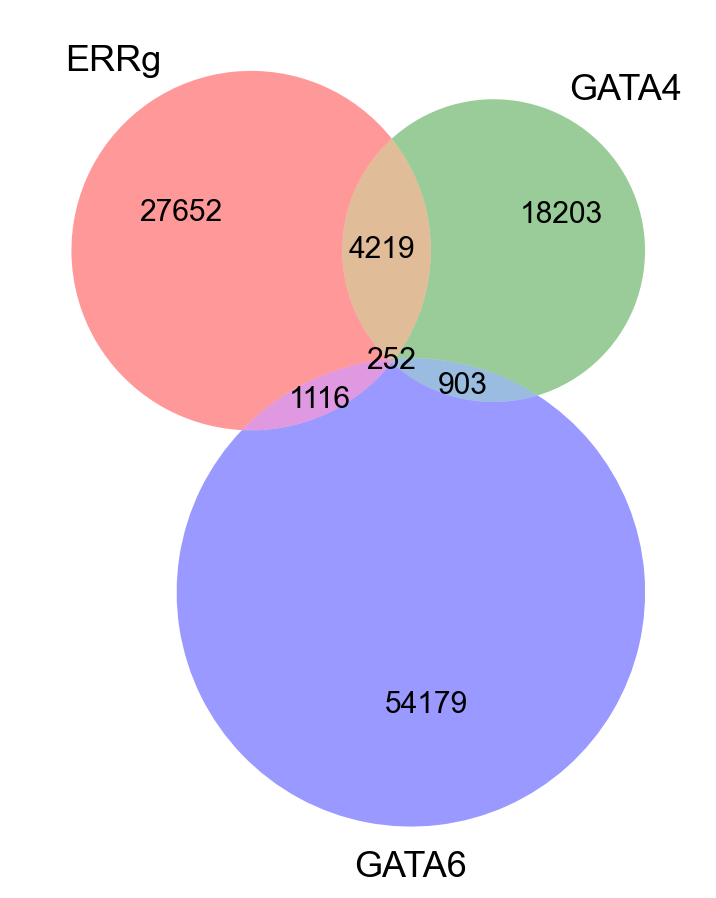

In [11]:
gata4_schrom_peaks = "data/ChIP-Seq/gata4/peaks/gata4_pooled.peaks"
gata4_lchrom_peaks = "data/ChIP-Seq/gata4/peaks/gata4_pooled.lchrom.peaks"
homer_tools.to_long_chromnames(gata4_schrom_peaks, gata4_lchrom_peaks)
plt.figure(figsize=(8, 8))
homer_tools.compare_peaks_3way("data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks", gata4_lchrom_peaks, gata6_peaks_file_hg38,
                               "ERRg", "GATA4", "GATA6", max_distance=400)

plt.savefig("pics/gata6/ERRg_GATA4_GATA6_venn.png", dpi=300)

In [ ]:
homer_tools.compare_peaks(wt_atac_lchrom, med1_peaks, "ATAC WT", "MED1", offsets={"11": (0, 50), "01": (20, 0)})

# MED1 / SEs

In [10]:
med1_data = pd.read_excel("data/ChIP-Seq/med1/mmc3.xlsx", sheet_name="WT_super", skiprows=5)
med1_data = med1_data[med1_data.isSuper == 1]
med1_se_hg19 = os.path.join(peaks_folder, "med1_se_hg19.bed")
med1_data[["CHROM", "START", "STOP", "REGION_ID"]].to_csv(med1_se_hg19, sep="\t", index=False, header=False)

In [11]:
med1_se_hg38 = os.path.join(peaks_folder, "med1_se_hg38.bed")
bedtools.liftover(med1_se_hg19, "hg19ToHg38", med1_se_hg38)
med1_se_hg38_peaks = os.path.join(peaks_folder, "med1_se_hg38.peaks")
homer_tools.bed_file_to_peak(med1_se_hg38, output_peaks=med1_se_hg38_peaks)

Running command w/120 threads: liftOver -bedPlus=5 'data/ChIP-Seq/gata6/peaks/med1_se_hg19.bed' reference/liftOver/hg19ToHg38.over.chain.gz 'data/ChIP-Seq/gata6/peaks/med1_se_hg38.bed' /dev/null
Running command w/120 threads: bed2pos.pl 'data/ChIP-Seq/gata6/peaks/med1_se_hg38.bed' -o 'data/ChIP-Seq/gata6/peaks/med1_se_hg38.peaks'


'data/ChIP-Seq/gata6/peaks/med1_se_hg38.peaks'

Running command w/120 threads: mergePeaks -d given 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.lchrom.peaks' 'data/ChIP-Seq/med1/peaks/med1_se_hg38.peaks' -matrix 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.lchrom.peaks.merged.matrix' -gsize 900000000.0 -venn 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.lchrom.peaks.merged.venn' > 'data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.lchrom.peaks.merged.peaks'


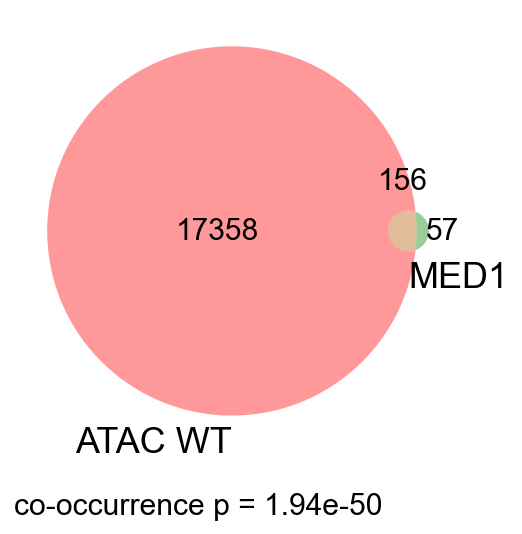

In [16]:
wt_atac_regions_file = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.peaks"
peaks_folder = "data/ChIP-Seq/med1/peaks/"
med1_se_hg38_peaks = os.patm h.join(peaks_folder, "med1_se_hg38.peaks")
med1_peaks = med1_se_hg38_peaks
wt_atac_lchrom = f"data/ATAC-Seq/hiPSCCM-ERRagKO/peaks/Cont_intersection.lchrom.peaks"
homer_tools.to_long_chromnames(wt_atac_regions_file, wt_atac_lchrom)
venn_file, _, _, _ = homer_tools.compare_peaks(wt_atac_lchrom, med1_peaks, "ATAC WT", "MED1", offsets={"11": (0, 50), "01": (20, 0)}, genome_size=9e8)
plt.savefig("pics/atac/atac_wt_med1_Srivastava.png", dpi=300)

In [63]:
merged_med1_atac_file = misc.replace_extension(venn_file, "peaks")
merged_peaks_data = pd.read_csv(merged_med1_atac_file, sep="\t")
merged_peaks_data = merged_peaks_data[merged_peaks_data["Total subpeaks"] > 1]
intersection_peaks = os.path.join(peaks_folder, "med1_atac_wt_intersection.peaks")
merged_peaks_data.to_csv(intersection_peaks, sep="\t", index=False)
intersection_annotated_peaks = os.path.join(peaks_folder, "med1_atac_wt_intersection.annotated.peaks")
homer_tools.annotate_peaks(intersection_peaks, intersection_annotated_peaks, "hg38", parallel_run.SimpleRunner())

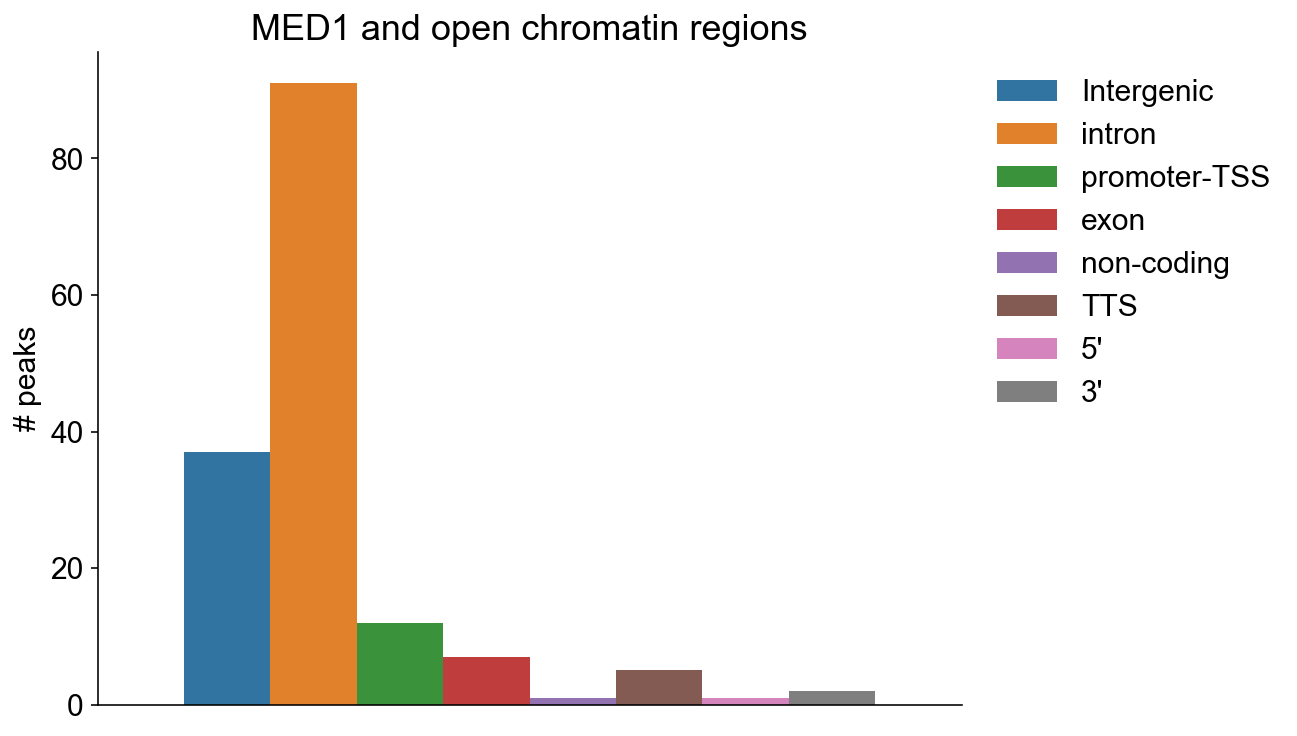

In [64]:
plt.figure(figsize=(10, 6))
homer_tools.plot_area_kind_distribution([("x", intersection_annotated_peaks)], "xxx")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xlabel("")
plt.xticks([])
plt.title("MED1 and open chromatin regions")
plt.subplots_adjust(wspace=1, right=0.7, left=0.1)
plt.savefig("pics/atac/atac_wt_med1_regions.png", dpi=300)

In [65]:
gene_id_map = pd.read_csv("data/gene_id_map_human.tsv", sep="\t")
gene_id_map = dict(zip(gene_id_map.id, gene_id_map.name))

In [66]:
peak_data = pd.read_csv(intersection_annotated_peaks, sep="\t")
wb = openpyxl.Workbook()
genes = set(peak_data["Nearest Ensembl"][~pd.isnull(peak_data["Nearest Ensembl"])])
ws = wb.create_sheet("Gene list")
misc.write_dataframe_to_worksheet(ws, pd.DataFrame({"gene_id": list(genes), "gene_name": [gene_id_map[g] for g in genes]}))

gprofiler.go_analysis_for_genes(genes, f"ATAC&MED1", gene_id_map, wb, 0.05, 2, "pics/atac/med1_atac_GO", "human")
del wb["Sheet"]
wb.save('tables/atac_wt_med1_Srivastava_intersection.xlsx')

Enrichment analysis for 144 genes in KEGG pathways...
Enrichment analysis for 144 genes in Molecular function...
Enrichment analysis for 144 genes in Cellular component...
Enrichment analysis for 144 genes in Biological process...


Running command w/120 threads: mergePeaks -d given 'data/ChIP-Seq/gata4/peaks/ERRg+GATA4.annotated.peaks' 'data/ChIP-Seq/gata6/peaks/med1_se_hg38.peaks' -venn 'data/ChIP-Seq/gata4/peaks/ERRg+GATA4.annotated.peaks.merged.venn' > 'data/ChIP-Seq/gata4/peaks/ERRg+GATA4.annotated.peaks.merged.peaks'
Exporting ERRg+GATA4_only
Create data/ChIP-Seq/med1/peaks/ERRg+GATA4_only.annotated.peaks
Running command w/120 threads: annotatePeaks.pl 'data/ChIP-Seq/med1/peaks/ERRg+GATA4_only.peaks' hg38     > 'data/ChIP-Seq/med1/peaks/ERRg+GATA4_only.annotated.peaks'
Save data/ChIP-Seq/med1/peaks/ERRg+GATA4_only.bed
Running command w/120 threads: pos2bed.pl 'data/ChIP-Seq/med1/peaks/ERRg+GATA4_only.annotated.peaks' -o 'data/ChIP-Seq/med1/peaks/ERRg+GATA4_only.bed'
Add [ERRg+GATA4_only peaks] to tables/ERRg+GATA4+SE_peaks.xlsx
Create pics/med1/ERRg+GATA4_only_peak_regions.png
Add [ERRg+GATA4_only|GO] to tables/ERRg+GATA4+SE_peaks.xlsx
Enrichment analysis for 3121 genes in KEGG pathways...
Enrichment analysi

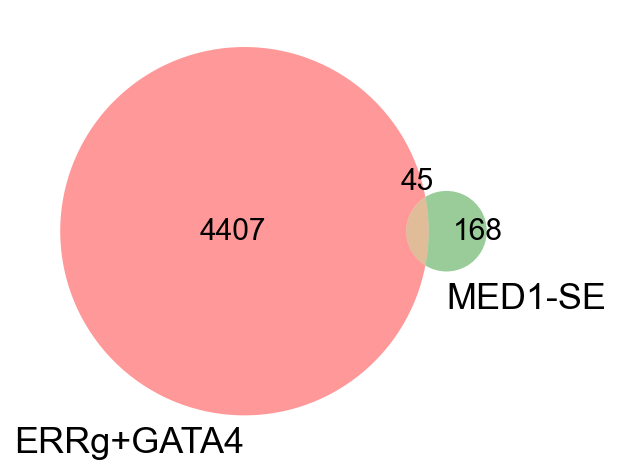

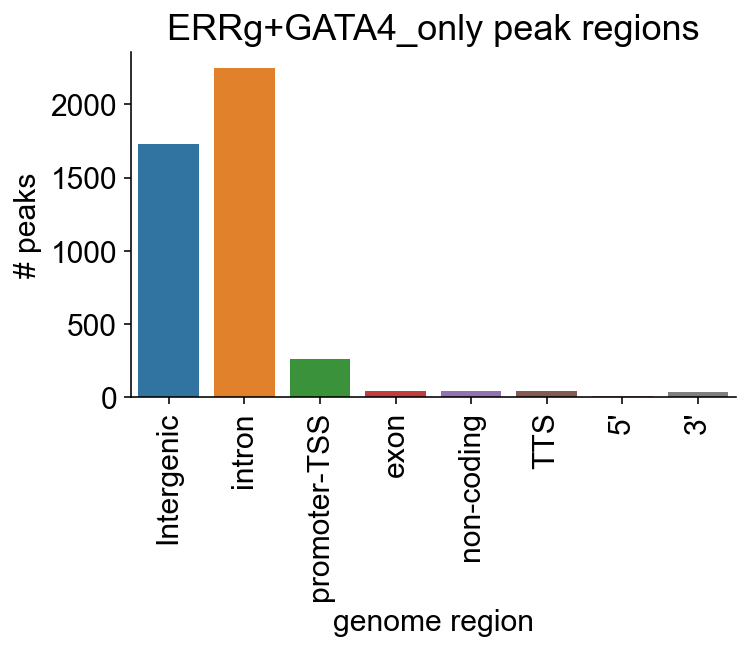

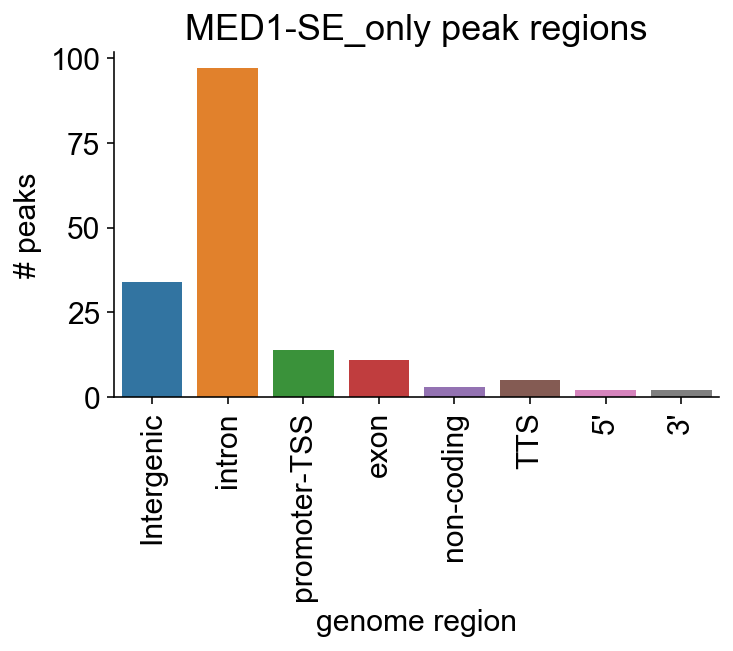

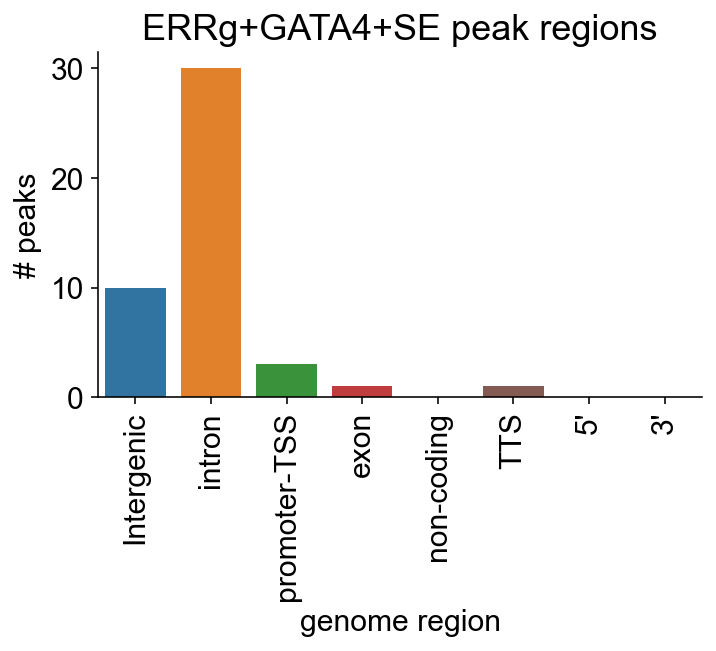

In [18]:
errg_gata4_peaks = f"data/ChIP-Seq/gata4/peaks/ERRg+GATA4.annotated.peaks"
med1_peaks = med1_se_hg38_peaks
peaks_folder = "data/ChIP-Seq/med1/peaks/"
pics_folder = "pics/med1"
homer_tools.compare_and_export_peaks(errg_gata4_peaks, med1_peaks, homer_genome,
                                     "human", gene_ids_map, "ERRg+GATA4", "MED1-SE", "ERRg+GATA4+SE", peaks_folder, pics_folder, "tables", chrom_names_are_short=False,
                                     venn_offsets={"11": (0, 50), "01": (20, 0)})

Running command w/120 threads: mergePeaks -d given 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks' 'data/ChIP-Seq/med1/peaks/med1_se_hg38.peaks' -matrix 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.matrix' -gsize 900000000.0 -venn 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.venn' > 'data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks.merged.peaks'
Exporting ERRg_only
Create data/ChIP-Seq/med1/peaks/ERRg_only.annotated.peaks
Running command w/120 threads: annotatePeaks.pl 'data/ChIP-Seq/med1/peaks/ERRg_only.peaks' hg38     > 'data/ChIP-Seq/med1/peaks/ERRg_only.annotated.peaks'
Save data/ChIP-Seq/med1/peaks/ERRg_only.bed
Running command w/120 threads: pos2bed.pl 'data/ChIP-Seq/med1/peaks/ERRg_only.annotated.peaks' -o 'data/ChIP-Seq/med1/peaks/ERRg_only.bed'
Add [ERRg_only peaks] to tables/ERRg+

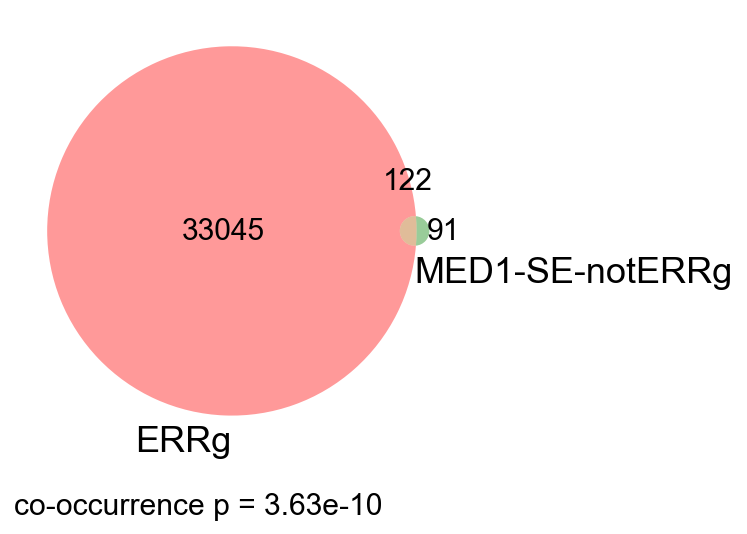

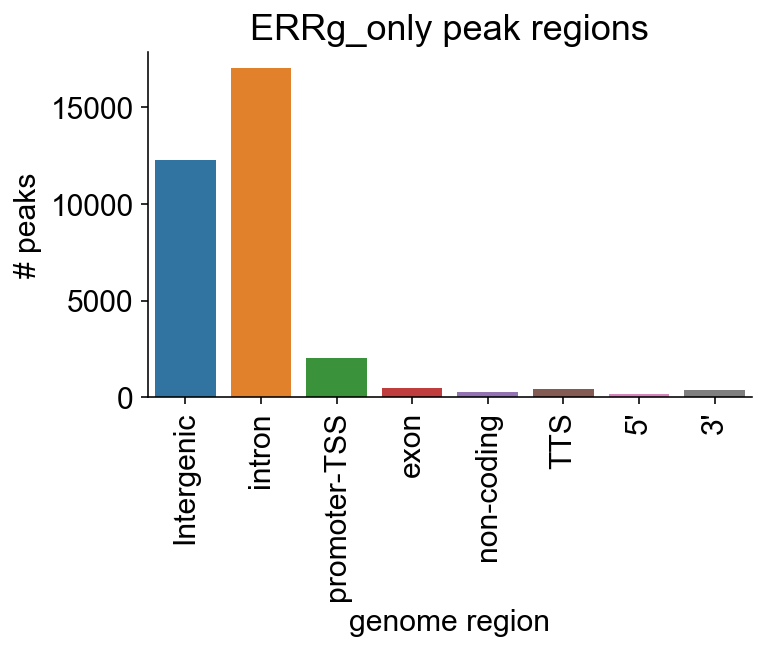

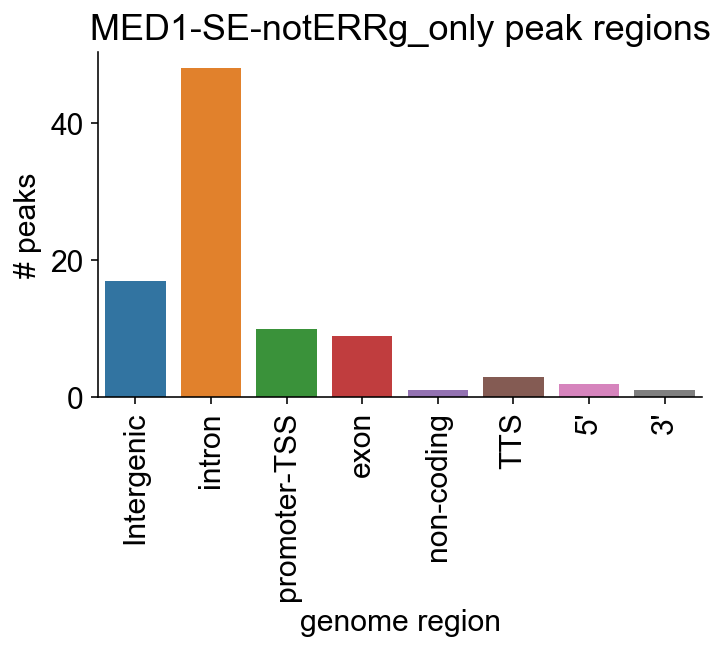

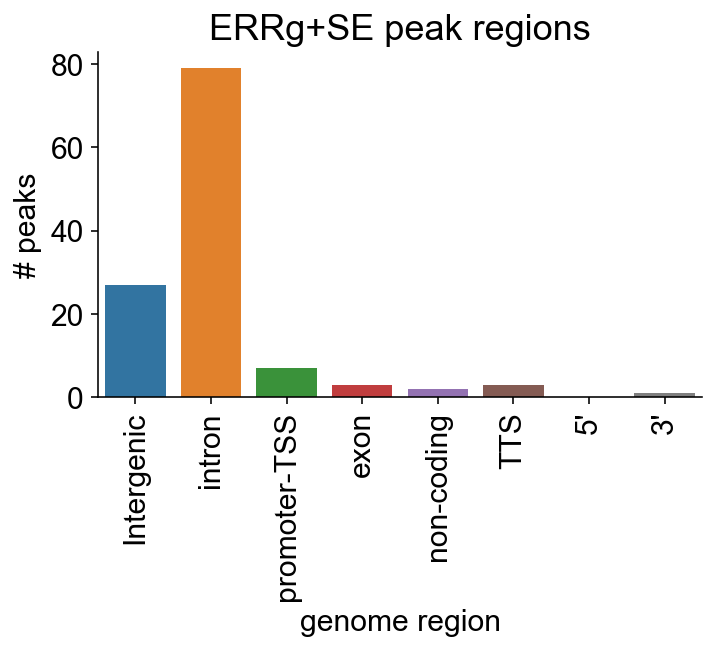

In [6]:
peaks_folder = "data/ChIP-Seq/med1/peaks/"
errg_peaks = f"data/ChIP-Seq/ERRg ChIP-seq in iPSC-CMs_Tomoya_2017/peaks/ERRg_WT_vs_KO_pooled_lchrom.peaks"
med1_se_hg38_peaks = os.path.join(peaks_folder, "med1_se_hg38.peaks")
med1_peaks = med1_se_hg38_peaks
pics_folder = "pics/med1"
homer_tools.compare_and_export_peaks(errg_peaks, med1_peaks, homer_genome,
                                     "human", "data/gene_id_map_human.tsv", "ERRg", "MED1-SE-notERRg", "ERRg+SE", peaks_folder, pics_folder, "tables", 
                                     chrom_names_are_short=False,
                                     venn_offsets={"11": (0, 50), "01": (20, 0)}, genome_size=9e8)

In [ ]:
homer_tools.compare_peaks("")